In [1]:
#Imports
import pandas as pd
import numpy as np

import pyomo.environ as pyo
import gurobipy as gp
from gurobipy import GRB

### Data Analysis

In [2]:
def generate_ems_data(data, ems_id):
        df = pd.DataFrame({f'net_load_{ems_id}': data[f'load_{ems_id}'] - data[f'pv_{ems_id}']})
        df['load'] = data[f'load_{ems_id}']
        df['pv'] = data[f'pv_{ems_id}']
        df['price'] = data["price"]
        
        return df

def build_model(data, bess_params):
        
        # Create a Gurobi model
        model = gp.Model("BESS_Optimization")

        # Extract time periods
        time_periods = data.index.to_list()

        # Precompute data
        load = data['load'].to_numpy()
        pv_gen = data['pv'].to_numpy()
        price = data['price'].to_numpy()
            
        # Decision Variables
        s_power  = model.addVars(time_periods, lb=-bess_params['s_max'], ub=bess_params['s_max'], name="s_power")
        SOC = model.addVars(time_periods, lb=bess_params['soc_min'], ub=bess_params['soc_max'], name="SOC")
        net_consumption = model.addVars(time_periods, lb=-100, ub=100, name="net_consumption")

        # ----------------------------
        # Add Constraints
        # ----------------------------
        
        # SOC Dynamics Constraints
        model.addConstrs(
        (SOC[t] == (bess_params['soc_init'] if t == time_periods[0] else SOC[time_periods[time_periods.index(t) - 1]]) + s_power[t] * bess_params['eta'] for t in time_periods),
            name="SOC_dynamics"
        )   

        model.addConstrs(
            (net_consumption[t] == load[time_periods.index(t)] - pv_gen[time_periods.index(t)] + s_power[t] for t in time_periods),
            name="NetConsumption"
        )

        # Objective function
        total_cost = gp.quicksum(price[time_periods.index(t)] * (load[time_periods.index(t)] - pv_gen[time_periods.index(t)] + s_power[t]) for t in time_periods)
        model.setObjective(total_cost, GRB.MINIMIZE)

        return model

def optimize_model(model):
        """
        Optimize the given Gurobi model.
        """
        # Set Gurobi parameters for better performance
        model.setParam('OutputFlag', 0)        # Suppress Gurobi output
        model.setParam('Threads', 8)            # Adjust based on your CPU (e.g., 8 threads for an 8-core CPU)
        model.setParam('Presolve', 2)           # Automatic presolve
        #model.setParam('Cuts', 2)               # Automatic cutting planes
        #model.setParam('Heuristics', 0.1)       # Allocate 10% of time to heuristics
        #model.Params.MIPGap = 0.01  # 1% optimality gap
        
        # Optimize the model
        model.optimize()
        return model

def extract_results(model, data):
        """
        Extract the optimization results and add them to the data DataFrame.
        """
        # Initialize lists to store variable values
        s_power_values = []
        SOC_values = []
        NetConsumption_Optimized = []

        # Iterate through each time period to extract variable values
        for t in data.index:
            # Extract s_power
            s_power_var = model.getVarByName(f"s_power[{t}]")
            s_power_values.append(s_power_var.X)
            
            # Extract SOC
            SOC_var = model.getVarByName(f"SOC[{t}]")
            SOC_values.append(SOC_var.X)
                

            # Calculate net consumption after optimization
            net_consumption = data.loc[t, 'load'] - data.loc[t, 'pv'] + s_power_values[-1]
            NetConsumption_Optimized.append(net_consumption)
        
        # Add extracted values to the DataFrame
        data['s_power'] = s_power_values
        data['SOC'] = SOC_values
        data['NetConsumption_Optimized'] = NetConsumption_Optimized

        return data


In [3]:
#Get data
data = pd.read_csv("../../data/Testing/Final_Energy_dataset.csv", header=0)
data['Date'] = pd.to_datetime(data['Date'])
data.fillna(0, inplace=True)

all_results = []
for id in range(300):
    print(f"Building {id+1}")

    ems_data = generate_ems_data(data, id+1)

    daily_mean_overproduction = (-ems_data[f'net_load_{id+1}'].clip(upper=0)).groupby(ems_data.index // 48).sum().mean().round(1)

    #Tesla Power Wall - Unscaled with basic setting
    """ bess_params = {
        'soc_init': 0,
        'soc_min': 0,
        'soc_max': 13.5,
        'eta': 1,
        's_max': 4.6,
        'bound': 100,
    }
    """

    # TeslaPowerWall Scaled to the Building
    bess_params = {
        'soc_init': 0,
        'soc_min': 0,
        'soc_max': daily_mean_overproduction,
        'eta': 1,
        's_max': (daily_mean_overproduction /3).round(1),
        'bound': 100,
    }

    model = build_model(ems_data, bess_params)

    model = optimize_model(model)

    results = extract_results(model, ems_data)
    
    # Rename columns to include building ID
    rename_dict = {
        'load': f'load_{id+1}',
        'pv': f'pv_{id+1}',
        's_power': f'bess_{id+1}',
        'NetConsumption_Optimized': f'netconsumption_{id+1}',
    }
    results_renamed = results.rename(columns=rename_dict)

    columns_to_keep = [
        f'load_{id+1}',
        f'pv_{id+1}',
        f'bess_{id+1}',
        f'netconsumption_{id+1}',
        f'price',
    ]
    results_renamed = results_renamed[columns_to_keep]

    # Store in the list
    all_results.append(results_renamed.reset_index(drop=True))

Building 1
Set parameter Username
Set parameter LicenseID to value 2593432
Academic license - for non-commercial use only - expires 2025-11-30
Building 2
Building 3
Building 4
Building 5
Building 6
Building 7
Building 8
Building 9
Building 10
Building 11
Building 12
Building 13
Building 14
Building 15
Building 16
Building 17
Building 18
Building 19
Building 20
Building 21
Building 22
Building 23
Building 24
Building 25
Building 26
Building 27
Building 28
Building 29
Building 30
Building 31
Building 32
Building 33
Building 34
Building 35
Building 36
Building 37
Building 38
Building 39
Building 40
Building 41
Building 42
Building 43
Building 44
Building 45
Building 46
Building 47
Building 48
Building 49
Building 50
Building 51
Building 52
Building 53
Building 54
Building 55
Building 56
Building 57
Building 58
Building 59
Building 60
Building 61
Building 62
Building 63
Building 64
Building 65
Building 66
Building 67
Building 68
Building 69
Building 70
Building 71
Building 72
Building 73
B

In [4]:
# 1. Concatenate (assuming all_results is your list of DataFrames)
final_df = pd.concat(all_results, axis=1)
final_df["date"] = pd.to_datetime(data['Date'])

# 2. Drop duplicate columns, keeping only the first occurrence
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

# 3. Reorder columns so that 'date' is first, then 'price', then the rest
columns_order = ['date', 'price'] + [col for col in final_df.columns if col not in ['date', 'price']]
final_df = final_df[columns_order]

final_df.to_csv("../../data/Energy_dataset_bessScaled.csv")

C:\Users\rs1044\AppData\Local\Temp\ipykernel_2324\2156033552.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  final_df["date"] = pd.to_datetime(data['Date'])


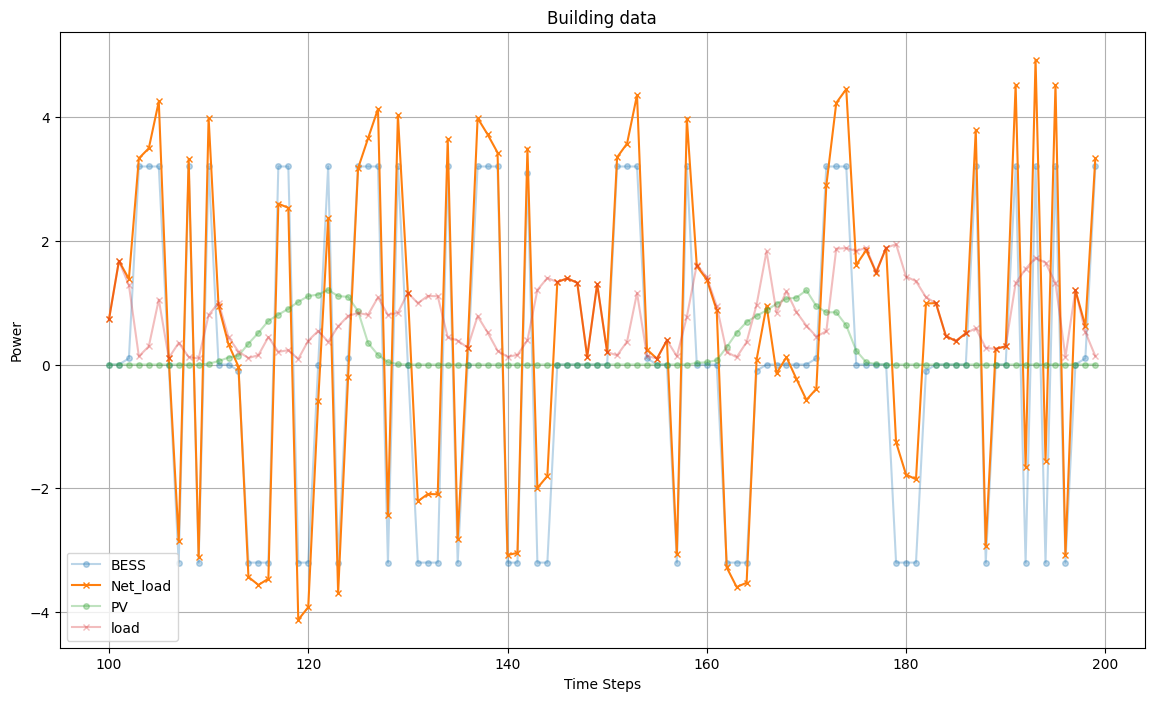

In [5]:
def plot_results(final_df, nr, start, end):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(14, 8))
    plt.plot(final_df[f"bess_{nr}"][start:end], label='BESS', marker='o', linestyle='-', markersize=4, alpha=0.3)
    plt.plot(final_df[f"netconsumption_{nr}"][start:end], label='Net_load', marker='x', linestyle='-', markersize=4)
    plt.plot(final_df[f"pv_{nr}"][start:end], label='PV', marker='o', linestyle='-', markersize=4, alpha=0.3)
    plt.plot(final_df[f"load_{nr}"][start:end], label='load', marker='x', linestyle='-', markersize=4, alpha=0.3)
    plt.title(f"Building data")
    plt.xlabel('Time Steps')
    plt.ylabel('Power')
    plt.legend()
    plt.grid()
    plt.show()

plot_results(final_df, nr=1, start=100, end=200)